# torchdataとは

[torchdata](https://pytorch.org/data/beta/index.html)とは，従来のdatasetを拡張するpytorchのモジュールです．

> torchdata is a library of common modular data loading primitives for easily constructing flexible and performant data pipelines.

2022/Aug時点で，まだベータ段階なのでAPIは今後変更がありますが，以下ではあまり変化がないと思われる利用方法を紹介します．

インストールはpipから．

In [ ]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 140 kB 45.8 MB/s 
     |████████████████████████████████| 127 kB 49.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


torchdataはdatapipe（処理のパイプライン）を作成して，そこにiteratorから取得したデータ要素を流して処理します．

datapipeはdpとしてimportします．

In [ ]:
import torchdata.datapipes as dp

torchdataの特徴は，このパイプラインであるdatapipeを，保存してあるデータ（やweb上のデータ）をパイプラインの起点として，終点であるデータローダーへと処理をつなげることです．

従来のpytorchのdatasetは，いろいろなフォーマットのデータを読み込んで処理してデータローダーへと受け渡すのは，ユーザーそれぞれに任されていました．ですので，いろいろな流儀のコードが巷に入り乱れることになりました．

単純な画像認識であれば，カテゴリごとのフォルダに学習画像を保存しておけばpytorchのImageFolderが使えるので簡単です．しかしセマンティックセグメンテーションでは，実画像とラベル画像のペアを別々のフォルダ（もしくは同一フォルダ）からペアで読み出す必要があります．物体検出なら実画像に対応したbboxデータは別のjsonやcsvに保存されているため，画像とcsv中のデータをペアにする必要があります．

torchdataのdatapipeは，そのような場合によく使われる処理を一括して統一的なAPIとして提供するものです．なれてしまえばdatapipeをつなげていくだけで処理のパイプラインができるので，いろいろな種類のデータの読み込みルーチンを統一的に書くことができます．

# データの準備

では例題用の学習データを用意します．小さいtoy exampleがよいので，ここではImageNetのサブセットである[imagenette](https://github.com/fastai/imagenette)の最小画像サイズを利用します．

In [ ]:
import requests
from pathlib import Path
import tarfile

def download(url):
    filename = Path(url).name
    with open(filename, 'wb') as save_file:
        save_file.write(requests.get(url).content)
    return filename

def tar_xzvf(filename, path='.'):
    with tarfile.open(filename, 'r:gz') as tar_file:
        tar_file.extractall(path=path)

def tar_tvf(filename):
    with tarfile.open(filename, 'r:') as tar_file:
        for i in range(10):
            info = tar_file.next()
            print(f'{info.gname}/{info.uname} {info.size:8d} {info.name}')

In [ ]:
filename = download('https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz')
tar_xzvf(filename)

これで`./imagenette2-160/train/`以下に学習画像が保存されました．

# pytorch標準のデータローダーの復習

では通常のpytorchのデータローダーの典型例を書いてみましょう．

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

単純にImageFolderを使った場合，`root`に画像フォルダを指定すれば，それ以下のサブフォルダはカテゴリとみなされてラベルは自動的に生成されます．

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = ImageFolder(
    './imagenette2-160/train/',
    transform=transform)

In [ ]:
for i, (img, label) in enumerate(dataset):
    print(img.shape, label)
    if i > 5:
        break

torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0


データローダーを使った場合．こちらが普通ですね．

In [ ]:
data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    )

In [ ]:
for i, (img, label) in enumerate(data_loader):
    print(img.shape, label)
    if i > 5:
        break

torch.Size([4, 3, 224, 224]) tensor([7, 9, 9, 2])
torch.Size([4, 3, 224, 224]) tensor([2, 4, 2, 1])
torch.Size([4, 3, 224, 224]) tensor([1, 4, 7, 0])
torch.Size([4, 3, 224, 224]) tensor([1, 9, 8, 6])
torch.Size([4, 3, 224, 224]) tensor([8, 9, 7, 4])
torch.Size([4, 3, 224, 224]) tensor([1, 1, 1, 7])
torch.Size([4, 3, 224, 224]) tensor([2, 5, 2, 6])


# torchdataの最初の例


ではtorchdataで同様のことを行ってみます．

torchdataは処理のパイプラインを構築します．そのために，まずはデータフォルダの中のファイルを取得してみましょう．

ここでは`torchdata.datapipes`を`dp`としてインポートします．



## FileLister：ファイルリストの取得

使うクラスは`dp.iter.FileLister`です．これは指定したフォルダ以下のファイル名を取得するものです．

この返り値が`datapipe`なので，それをイテレータとして最初の10個の要素を表示したのが以下のコードです．

In [ ]:
import torchdata.datapipes as dp

data_root = './imagenette2-160/train/'
datapipe = dp.iter.FileLister(
    data_root,
    recursive=True
    )

for i, d in enumerate(datapipe):
    print(i, d)
    if i > 10:
        break

0 ./imagenette2-160/train/.DS_Store
1 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG
2 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG
3 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG
4 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG
5 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG
6 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009346.JPEG
7 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009379.JPEG
8 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009396.JPEG
9 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00010306.JPEG
10 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011233.JPEG
11 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011993.JPEG


## Filter：データ要素のふるい分け

しかしJPEGではないファイルも混じってしまっています．

そこで登場するのが`dp.iter.Filter`です．これは引数に指定した関数が，各要素をパイプラインの次に伝えるかどうかを真偽値で決定します．その関数がTrueなら次に伝わり，Falseなら伝わりません．

In [ ]:
import torchdata.datapipes as dp

data_root = './imagenette2-160/train/'
datapipe = dp.iter.FileLister(
    data_root,
    recursive=True
    )
datapipe = dp.iter.Filter(
    datapipe,
    filter_fn=lambda x: x.endswith("JPEG")
    )

for i, d in enumerate(datapipe):
    print(i, d)
    if i > 10:
        break

0 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG
1 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG
2 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG
3 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG
4 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG
5 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009346.JPEG
6 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009379.JPEG
7 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009396.JPEG
8 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00010306.JPEG
9 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011233.JPEG
10 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011993.JPEG
11 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00012503.JPEG



たしかにJPEGファイル名だけが取りだされているのがわかります．

## functional形式：その1


上記の例はコンストラクタを利用していますが，functional形式で以下のように書くこともできます．これはdatapipeオブジェクトを生成して，そのメソッドの返り値をまたdatapipeに代入する，という方法です．

In [ ]:
import torchdata.datapipes as dp

data_root = './imagenette2-160/train/'
datapipe = dp.iter.FileLister(
    data_root,
    recursive=True
    )
datapipe = datapipe.filter(
    filter_fn=lambda x: x.endswith("JPEG")
    )

for i, d in enumerate(datapipe):
    print(i, d)
    if i > 10:
        break

0 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG
1 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG
2 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG
3 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG
4 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG
5 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009346.JPEG
6 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009379.JPEG
7 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009396.JPEG
8 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00010306.JPEG
9 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011233.JPEG
10 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011993.JPEG
11 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00012503.JPEG



## functional形式：その2

これは以下のように連続して書くこともできます．これは最初に生成したdatapipeオブジェクトにメソッドを追加していく方法で，最終的に出来上がったものを左辺の変数datapipeに代入しています．

In [ ]:
import torchdata.datapipes as dp

data_root = './imagenette2-160/train/'
datapipe = dp.iter.FileLister(
        data_root,
        recursive=True
    ).filter(
        filter_fn=lambda x: x.endswith("JPEG")
    )

for i, d in enumerate(datapipe):
    print(i, d)
    if i > 10:
        break

0 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG
1 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG
2 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG
3 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG
4 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG
5 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009346.JPEG
6 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009379.JPEG
7 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009396.JPEG
8 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00010306.JPEG
9 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011233.JPEG
10 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011993.JPEG
11 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00012503.JPEG



## functional形式：その2-2

以下のコードでは改行する場所を変更して，処理毎に行にまとめています．

In [ ]:
import torchdata.datapipes as dp

data_root = './imagenette2-160/train/'
datapipe = (
    dp.iter.FileLister(data_root, recursive=True)
    .filter(filter_fn=lambda x: x.endswith("JPEG"))
)

for i, d in enumerate(datapipe):
    print(i, d)
    if i > 10:
        break

0 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG
1 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG
2 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG
3 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG
4 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG
5 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009346.JPEG
6 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009379.JPEG
7 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009396.JPEG
8 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00010306.JPEG
9 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011233.JPEG
10 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011993.JPEG
11 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00012503.JPEG


以下ではdatapipeに繰り返し代入する記法で説明します．
こうすると，途中までのdatapipeで処理を打ち切って表示すれば，その時点でどんな要素になっているのかを確認できるという利点があります．（ただしofficialのtorchdataのサンプルコードはこの記法になっていないので注意してください）


# ファイルのオープン


JPEGファイル名が取得できたので，次はそのファイルを[`.open_files()`](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.FileOpener.html#torchdata.datapipes.iter.FileOpener)でオープンします．返り値は，ファイル名とそのファイルオブジェクトのタプルです．（オブジェクトの方は[StreamWrapper](https://pytorch.org/data/beta/generated/torchdata.datapipes.utils.StreamWrapper.html)になっていますが，これは確実にクローズするためのラッパーです）

openするためのmodeはバイナリ"b"です．これは今からオープンしようとしているファイルがJPEGファイルだからです．テキストファイルなら"t"を指定します．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import io

data_root = './imagenette2-160/train/'
datapipe = dp.iter.FileLister(
    data_root,
    recursive=True)
datapipe = datapipe.filter(
    filter_fn=lambda x: x.endswith("JPEG"))
datapipe = datapipe.open_files(mode="b")

for i, d in enumerate(datapipe):
    print(i, d)
    if i > 10:
        break

0 ('./imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG', StreamWrapper<<_io.BufferedReader name='./imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG'>>)
1 ('./imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG', StreamWrapper<<_io.BufferedReader name='./imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG'>>)
2 ('./imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG', StreamWrapper<<_io.BufferedReader name='./imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG'>>)
3 ('./imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG', StreamWrapper<<_io.BufferedReader name='./imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG'>>)
4 ('./imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG', StreamWrapper<<_io.BufferedReader name='./imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG'>>)
5 ('./imagenette2-160/train/n01440764/ILSVRC2012_val_00009346.JPEG', StreamWrapper<<_io.BufferedReader name='./imagenett

# map：各要素への処理の適用

画像ファイルとしてオープンするなら，`PIL.Image.open()`が使えます．そのために利用するのが[`.map()`](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.Mapper.html#torchdata.datapipes.iter.Mapper)です．これは指定した関数を各要素に適用するmapです．

以下では，`Image.open()`を各要素にmapで適用しています．ここまでの流れをおさらいしましょう．

- `dp.iter.FileLister`でファイルリストを取得し，その中のファイル名をひとつずつdatapipeに流す
- `filter`で，ファイル名がJPEGで終わっているものだけを次のdatapipeへ受け渡す
- `map`で，受け渡されたJPEGファイルをオープンして`PIL.Image`型のオブジェクトを次のdatapipeへ受け渡す

処理のパイプラインはこれで終わりなので，datapipeをイテレータとして要素を取得すると，`PIL.Image`型のオブジェクトが得られます．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image

data_root = './imagenette2-160/train/'
datapipe = dp.iter.FileLister(
    data_root,
    recursive=True)
datapipe = datapipe.filter(
    filter_fn=lambda x: x.endswith("JPEG"))
datapipe = datapipe.map(
    lambda x: Image.open(x))

for i, d in enumerate(datapipe):
    print(i, d)
    if i > 10:
        break

0 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=213x160 at 0x7F01DB757650>
1 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=213x160 at 0x7F01D674D690>
2 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=213x160 at 0x7F01D674D590>
3 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=213x160 at 0x7F01D674DA90>
4 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=213x160 at 0x7F01D6746190>
5 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=213x160 at 0x7F01D67463D0>
6 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=213x160 at 0x7F01D6746610>
7 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=213x160 at 0x7F01D6746850>
8 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=200x160 at 0x7F01D6746A90>
9 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=187x160 at 0x7F01D6746CD0>
10 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=213x160 at 0x7F01D6746F10>
11 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=213x160 at 0x7F01

## ndarrayへの変換

map中の関数で以下のようにndarrayにもできます．これでようやくデータローダーっぽくなってきました．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np

data_root = './imagenette2-160/train/'
datapipe = dp.iter.FileLister(
    data_root,
    recursive=True)
datapipe = datapipe.filter(
    filter_fn=lambda x: x.endswith("JPEG"))
datapipe = datapipe.map(
    lambda x: np.array(Image.open(x)))

for i, d in enumerate(datapipe):
    print(i, d.shape, type(d))
    if i > 10:
        break

0 (160, 213, 3) <class 'numpy.ndarray'>
1 (160, 213, 3) <class 'numpy.ndarray'>
2 (160, 213, 3) <class 'numpy.ndarray'>
3 (160, 213, 3) <class 'numpy.ndarray'>
4 (160, 213, 3) <class 'numpy.ndarray'>
5 (160, 213, 3) <class 'numpy.ndarray'>
6 (160, 213, 3) <class 'numpy.ndarray'>
7 (160, 213, 3) <class 'numpy.ndarray'>
8 (160, 200, 3) <class 'numpy.ndarray'>
9 (160, 187, 3) <class 'numpy.ndarray'>
10 (160, 213, 3) <class 'numpy.ndarray'>
11 (160, 213, 3) <class 'numpy.ndarray'>


# open_files()の動作

先程のコードは，ファイル名から直接`PIL.Image.open()`で画像ファイルをオープンしていました．

ところが`.open_files()`でオープンした後でも`PIL.Image.open()`は使えます．先程見たように，`.open_files()`の返り値は，ファイル名とそのファイルオブジェクトのタプルです．すると，datapipeの次の処理では，タプルの要素ごとに処理を適用できます．

以下では，タプルの第1要素`x[0]`はファイル名なので，そのまま返り値のタプルの第1要素にしています．タプルの第2要素`x[1]`はオープンされたバイナリ列なので，それを`PIL.Image.open()`に渡しndarrayに変換します．

こうすると，作成されたdatapipeから要素を取り出すと，ファイル名とndarrayのタプルが得られます．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np

data_root = './imagenette2-160/train/'
datapipe = dp.iter.FileLister(
    data_root,
    recursive=True
    )
datapipe = datapipe.filter(
    filter_fn=lambda x: x.endswith("JPEG"))
datapipe = datapipe.open_files(mode='b')
datapipe = datapipe.map(
    lambda x: (x[0], np.array(Image.open(x[1])))
    )

for i, d in enumerate(datapipe):
    print(i, d[0], d[1].shape, type(d[1]))
    if i > 10:
        break

0 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG (160, 213, 3) <class 'numpy.ndarray'>
1 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG (160, 213, 3) <class 'numpy.ndarray'>
2 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG (160, 213, 3) <class 'numpy.ndarray'>
3 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG (160, 213, 3) <class 'numpy.ndarray'>
4 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG (160, 213, 3) <class 'numpy.ndarray'>
5 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009346.JPEG (160, 213, 3) <class 'numpy.ndarray'>
6 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009379.JPEG (160, 213, 3) <class 'numpy.ndarray'>
7 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009396.JPEG (160, 213, 3) <class 'numpy.ndarray'>
8 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00010306.JPEG (160, 200, 3) <class 'numpy.ndarray'>
9 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011233.JPEG (160, 18

# ファイル名のフルパスからカテゴリラベルを取り出す

学習のためにはラベルと画像のペアが必要になります．このデータセットでは，ラベルは画像が保存されているディレクトリ名から取得します．

以下のように`pathlib.Path`を利用すると，ファイル名からラベルを取得し，ファイルから画像を取得することができます．

- まず`Path(path)`でフルパスを`Path`オブジェクトに変換します
- 次に`Path(path).parent`で，ファイルが含まれているディレクトリのフルパスを取得します．
- 最後に`Path(path).parent.stem`で，ディレクトリ部分だけを取得します．

またファイル名からカテゴリを抜き出す関数`decode_label`と，バイナリ列を読み込んでPIL.Imageにする関数`decode_image`を用意しました．これをmapでタプルの要素のそれぞれに適用しています．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

data_root = './imagenette2-160/train/'
datapipe = dp.iter.FileLister(
    data_root,
    recursive=True
    )
datapipe = datapipe.filter(
    filter_fn=lambda x: x.endswith("JPEG"))
datapipe = datapipe.open_files(mode='b')

def decode_label(path):
    return Path(path).parent.stem
def decode_image(stream):
    return np.array(Image.open(stream))

datapipe = datapipe.map(
    lambda x: (decode_label(x[0]), decode_image(x[1])))

for i, d in enumerate(datapipe):
    print(i, d[0], d[1].shape, type(d[1]))
    if i > 10:
        break

0 n01440764 (160, 213, 3) <class 'numpy.ndarray'>
1 n01440764 (160, 213, 3) <class 'numpy.ndarray'>
2 n01440764 (160, 213, 3) <class 'numpy.ndarray'>
3 n01440764 (160, 213, 3) <class 'numpy.ndarray'>
4 n01440764 (160, 213, 3) <class 'numpy.ndarray'>
5 n01440764 (160, 213, 3) <class 'numpy.ndarray'>
6 n01440764 (160, 213, 3) <class 'numpy.ndarray'>
7 n01440764 (160, 213, 3) <class 'numpy.ndarray'>
8 n01440764 (160, 200, 3) <class 'numpy.ndarray'>
9 n01440764 (160, 187, 3) <class 'numpy.ndarray'>
10 n01440764 (160, 213, 3) <class 'numpy.ndarray'>
11 n01440764 (160, 213, 3) <class 'numpy.ndarray'>


# globのファイルリストからdatapipeオブジェクトを作成

さてここまでは`dp.iter.FileLister`を使ってきましたが，通常のファイルリストも与えることができます．

以下は，globで取得したjpegファイル名のリストを，`dp.iter.IterableWrapper`に与えています．その後は処理は同様です．ただし`my_decoder`を作成して，タプルを受け取りタプルを返すようにしています．こうするとdatapipe作成部分からlambdaが不要になるので少しスッキリします．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

data_root = './imagenette2-160/train/'
file_paths = [
    str(path) for path in Path(data_root).glob('*/*')
    if not path.is_dir() 
        and path.name.endswith((
            '.JPEG', '.jpeg', '.jpg',
        ))
]
print("number of files:", len(file_paths))

def decode_label(path):
    return Path(path).parent.stem
def decode_image(stream):
    return np.array(Image.open(stream))
def my_decoder(x):
    return decode_label(x[0]), decode_image(x[1])

datapipe = dp.iter.IterableWrapper(file_paths)
datapipe = datapipe.open_files(mode='b')
datapipe = datapipe.map(my_decoder)

for i, d in enumerate(datapipe):
    print(i, d[0], d[1].shape, type(d[1]))
    if i > 10:
        break

number of files: 9469
0 n03425413 (213, 160, 3) <class 'numpy.ndarray'>
1 n03425413 (160, 160, 3) <class 'numpy.ndarray'>
2 n03425413 (213, 160, 3) <class 'numpy.ndarray'>
3 n03425413 (213, 160, 3) <class 'numpy.ndarray'>
4 n03425413 (240, 160, 3) <class 'numpy.ndarray'>
5 n03425413 (160, 214, 3) <class 'numpy.ndarray'>
6 n03425413 (160, 213, 3) <class 'numpy.ndarray'>
7 n03425413 (217, 160, 3) <class 'numpy.ndarray'>
8 n03425413 (213, 160, 3) <class 'numpy.ndarray'>
9 n03425413 (160, 213, 3) <class 'numpy.ndarray'>
10 n03425413 (213, 160, 3) <class 'numpy.ndarray'>
11 n03425413 (160, 238, 3) <class 'numpy.ndarray'>


# tar.gzから直接データを読み込み

さてtorchdataの面白いところは，ダウンロードしてきた`.tar.gz`などのアーカイブを，展開せずそのまま使えることです．（有用かどうかはともかく）



## tarファイルのオープン

そのためには，`FileLister`でtar.gzまたはtgzのファイル（のリスト）を指定します．続くパイプラインではそのtgzファイルを`.open_files()`でオープンします．その次には`.load_from_tar()`を使って，tarファイルから要素を一つづつ逐次的に読み出します．

`.load_from_tar()`は，tarファイル中のファイル名と読み込んだバイナリ列を，タプルで返していることがわかります．

In [ ]:
import torchdata.datapipes as dp

tar_filename = './imagenette2-160.tgz'
datapipe = dp.iter.FileLister([tar_filename])
datapipe = datapipe.open_files(mode='b')
datapipe = datapipe.load_from_tar()

for i, d in enumerate(datapipe):
    print(i, d)
    if i > 10:
        break

0 ('imagenette2-160.tgz/imagenette2-160/.DS_Store', StreamWrapper<<ExFileObject name='./imagenette2-160.tgz'>>)
1 ('imagenette2-160.tgz/imagenette2-160/noisy_imagenette.csv', StreamWrapper<<ExFileObject name='./imagenette2-160.tgz'>>)
2 ('imagenette2-160.tgz/imagenette2-160/val/n02979186/n02979186_7492.JPEG', StreamWrapper<<ExFileObject name='./imagenette2-160.tgz'>>)
3 ('imagenette2-160.tgz/imagenette2-160/val/n02979186/n02979186_491.JPEG', StreamWrapper<<ExFileObject name='./imagenette2-160.tgz'>>)
4 ('imagenette2-160.tgz/imagenette2-160/val/n02979186/n02979186_24591.JPEG', StreamWrapper<<ExFileObject name='./imagenette2-160.tgz'>>)
5 ('imagenette2-160.tgz/imagenette2-160/val/n02979186/n02979186_26451.JPEG', StreamWrapper<<ExFileObject name='./imagenette2-160.tgz'>>)
6 ('imagenette2-160.tgz/imagenette2-160/val/n02979186/n02979186_11372.JPEG', StreamWrapper<<ExFileObject name='./imagenette2-160.tgz'>>)
7 ('imagenette2-160.tgz/imagenette2-160/val/n02979186/n02979186_1792.JPEG', StreamW

では先程までと同様にJPEG画像をカテゴリ名とペアで読み込んでみましょう．

画像を読み込むだけなら，`.load_from_tar()`が返すタプルの第2要素を`PIL.Image.open()`でオープンするだけです．
以下のコードでは，データをtar.gzから直接読み込む以外は，今までの説明のコードと全く同様になっています．


In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

tar_filename = './imagenette2-160.tgz'

def decode_label(path):
    return Path(path).parent.stem
def decode_image(stream):
    return np.array(Image.open(stream))
def my_decoder(x):
    return decode_label(x[0]), decode_image(x[1])

datapipe = dp.iter.FileLister([tar_filename])
datapipe = datapipe.open_files(mode='b')
datapipe = datapipe.load_from_tar()
datapipe = datapipe.filter(
    filter_fn=lambda x: x[0].endswith("JPEG"))
datapipe = datapipe.map(my_decoder)

for i, d in enumerate(datapipe):
    print(i, d[0], d[1].shape, type(d[1]))
    if i > 10:
        break

0 n02979186 (160, 164, 3) <class 'numpy.ndarray'>
1 n02979186 (160, 316, 3) <class 'numpy.ndarray'>
2 n02979186 (160, 213, 3) <class 'numpy.ndarray'>
3 n02979186 (160, 210, 3) <class 'numpy.ndarray'>
4 n02979186 (160, 198, 3) <class 'numpy.ndarray'>
5 n02979186 (213, 160, 3) <class 'numpy.ndarray'>
6 n02979186 (160, 262, 3) <class 'numpy.ndarray'>
7 n02979186 (160, 234, 3) <class 'numpy.ndarray'>
8 n02979186 (160, 183, 3) <class 'numpy.ndarray'>
9 n02979186 (160, 187, 3) <class 'numpy.ndarray'>
10 n02979186 (160, 213, 3) <class 'numpy.ndarray'>
11 n02979186 (160, 204, 3) <class 'numpy.ndarray'>


## web上のtar.gzファイルのオープン

torchdatsetは，ローカルファイル以外でもtar.gzを読み込むことができます．

以下のように，tarファイルのURLを`dp.iter.IterableWrapper`に渡します．それを，ローカルファイルのように`.open_files()`を使ってオープンするのではなく，`.read_from_http()`を使ってダウンロード（ストリーミング）します．

あとはローカルのtarファイルを読み込むパイプラインと同様です．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

tar_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz'

def decode_label(path):
    return Path(path).parent.stem
def decode_image(stream):
    return np.array(Image.open(stream))
def my_decoder(x):
    return decode_label(x[0]), decode_image(x[1])

datapipe = dp.iter.IterableWrapper([tar_url])
datapipe = datapipe.read_from_http()
datapipe = datapipe.load_from_tar()
datapipe = datapipe.filter(
    filter_fn=lambda x: x[0].endswith("JPEG"))
datapipe = datapipe.map(my_decoder)

for i, d in enumerate(datapipe):
    print(i, d[0], d[1].shape, type(d[1]))
    if i > 10:
        break

0 n02979186 (160, 164, 3) <class 'numpy.ndarray'>
1 n02979186 (160, 316, 3) <class 'numpy.ndarray'>
2 n02979186 (160, 213, 3) <class 'numpy.ndarray'>
3 n02979186 (160, 210, 3) <class 'numpy.ndarray'>
4 n02979186 (160, 198, 3) <class 'numpy.ndarray'>
5 n02979186 (213, 160, 3) <class 'numpy.ndarray'>
6 n02979186 (160, 262, 3) <class 'numpy.ndarray'>
7 n02979186 (160, 234, 3) <class 'numpy.ndarray'>
8 n02979186 (160, 183, 3) <class 'numpy.ndarray'>
9 n02979186 (160, 187, 3) <class 'numpy.ndarray'>
10 n02979186 (160, 213, 3) <class 'numpy.ndarray'>
11 n02979186 (160, 204, 3) <class 'numpy.ndarray'>


ネットからダウンロードしつつ学習に用いるというのは，有用な場合もありますが，以下ではローカルファイルを扱う方法で説明します．

# FileListerでファイル名指定

JPEGファイル名を取得するには，先程は`filter`を使っていましたが，以下のように[`FileLister`の`masks`オプション](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.FileLister.html)で指定してもOKです．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

def my_decoder(x):
    return Path(x[0]).name, \
        np.array(Image.open(x[1]))
        
data_root = './imagenette2-160/train/'
datapipe = dp.iter.FileLister(
    data_root, masks=["*.JPEG", "*.jpeg", "*.jpg"], recursive=True)
datapipe = datapipe.open_files(mode='b')
datapipe = datapipe.map(my_decoder)

for i, d in enumerate(datapipe):
    print(i, d[0], d[1].shape, type(d[1]))
    if i > 10:
        break

0 ILSVRC2012_val_00000293.JPEG (160, 213, 3) <class 'numpy.ndarray'>
1 ILSVRC2012_val_00002138.JPEG (160, 213, 3) <class 'numpy.ndarray'>
2 ILSVRC2012_val_00003014.JPEG (160, 213, 3) <class 'numpy.ndarray'>
3 ILSVRC2012_val_00006697.JPEG (160, 213, 3) <class 'numpy.ndarray'>
4 ILSVRC2012_val_00007197.JPEG (160, 213, 3) <class 'numpy.ndarray'>
5 ILSVRC2012_val_00009346.JPEG (160, 213, 3) <class 'numpy.ndarray'>
6 ILSVRC2012_val_00009379.JPEG (160, 213, 3) <class 'numpy.ndarray'>
7 ILSVRC2012_val_00009396.JPEG (160, 213, 3) <class 'numpy.ndarray'>
8 ILSVRC2012_val_00010306.JPEG (160, 200, 3) <class 'numpy.ndarray'>
9 ILSVRC2012_val_00011233.JPEG (160, 187, 3) <class 'numpy.ndarray'>
10 ILSVRC2012_val_00011993.JPEG (160, 213, 3) <class 'numpy.ndarray'>
11 ILSVRC2012_val_00012503.JPEG (160, 213, 3) <class 'numpy.ndarray'>


# データパイプの分岐と合流

さてtorchdataのパイプラインのさらなる面白いところは，パイプラインを分岐したり合流點せたりできることです．


## fork：データパイプのコピー

ではまずdatapipeを分岐する方法を説明します．それには[`.fork()`](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.Forker.html#torchdata.datapipes.iter.Forker)を使います．引数にはいくつに分岐するかの数を指定します．返り値は，指定した数のdatapipeからなるタプルです．

以下で見るように，まったく同じ内容のパイプラインができていることがわかります．

In [ ]:
import torchdata.datapipes as dp

data_root = './imagenette2-160/train/'

datapipe = dp.iter.FileLister(
    data_root, recursive=True)
dp1, dp2 = datapipe.fork(2)

for i, d in enumerate(dp1):
    print(i, d)
    if i > 10:
        break

for i, d in enumerate(dp2):
    print(i, d)
    if i > 10:
        break

0 ./imagenette2-160/train/.DS_Store
1 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG
2 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG
3 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG
4 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00006697.JPEG
5 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00007197.JPEG
6 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009346.JPEG
7 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009379.JPEG
8 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00009396.JPEG
9 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00010306.JPEG
10 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011233.JPEG
11 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00011993.JPEG
0 ./imagenette2-160/train/.DS_Store
1 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG
2 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00002138.JPEG
3 ./imagenette2-160/train/n01440764/ILSVRC2012_val_00003014.JPEG
4 ./imagenette2-

ただし分岐したと言っても全く別物になっているわけではありません．同じところから（この場合はファイルリスト）から要素をキャッシュして擬似的に同期をとって使っているため，片方だけの要素を使い切ろうとすると，エラーになります．（これはIterDataPipeの場合です）

以下のコードを実行すると，要素のキャッシュのためのバッファサイズ（デフォルトで1000）を使い切ってしまったというエラーが出ます．

In [ ]:
# import torchdata.datapipes as dp

# data_root = './imagenette2-160/train/'

# datapipe = dp.iter.FileLister(
#     data_root, recursive=True)
# dp1, dp2 = datapipe.fork(2)

# for i, d in enumerate(dp1):
#     pass

# for i, d in enumerate(dp2):
#     print(i, d)
#     if i > 10:
#         break

## zip：データパイプの合流

### 通常のzip

以下では，2つに分岐したパイプラインのそれぞれで処理をしてから，zipで固めて一緒にループを回している例です．

[pythonのzip()](https://docs.python.org/ja/3/library/functions.html#zip)は，短い方のイテレータに合わせて終了します．以下でそれを見るために，ここで最後までループを回して，要素数がいくつなのかを表示してみましょう．


なお，データパイプで取得できる要素数がいくつかのかは，事前には（つまりイテレータが要素を使い尽くす前は）分かりません．これはdatapipeが，ローカルのファイル名を列挙するようなやり方だけでなく．tar.gzのようなアーカイブファイルから逐次的に要素を取り出したり，web上のtar.gzからストリーミングして要素を取り出したりするような方法も統一的に扱うようにするためです．そのような方法（逐次的に要素を取り出す方法）は，最後まで取りださないと，要素数がいくつなのかは不明です．そのため，datapipeに対して`len()`は定義されていません（[定義できますが推奨されていません](https://pytorch.org/data/beta/tutorial.html#length)）．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

data_root = './imagenette2-160/train/'

datapipe = dp.iter.FileLister(
    data_root, masks=["*.JPEG", "*.jpeg", "*.jpg"], recursive=True)
dp1, dp2 = datapipe.fork(2)

dp1 = dp1.map(lambda x: Path(x).name)
dp2 = dp2.map(lambda x: np.array(Image.open(x)))

for i, (d1, d2) in enumerate(zip(dp1, dp2)):
    if i < 10:
        print(i, d1, d2.shape, type(d2))
print("total number of items: ", i + 1)

0 ILSVRC2012_val_00000293.JPEG (160, 213, 3) <class 'numpy.ndarray'>
1 ILSVRC2012_val_00002138.JPEG (160, 213, 3) <class 'numpy.ndarray'>
2 ILSVRC2012_val_00003014.JPEG (160, 213, 3) <class 'numpy.ndarray'>
3 ILSVRC2012_val_00006697.JPEG (160, 213, 3) <class 'numpy.ndarray'>
4 ILSVRC2012_val_00007197.JPEG (160, 213, 3) <class 'numpy.ndarray'>
5 ILSVRC2012_val_00009346.JPEG (160, 213, 3) <class 'numpy.ndarray'>
6 ILSVRC2012_val_00009379.JPEG (160, 213, 3) <class 'numpy.ndarray'>
7 ILSVRC2012_val_00009396.JPEG (160, 213, 3) <class 'numpy.ndarray'>
8 ILSVRC2012_val_00010306.JPEG (160, 200, 3) <class 'numpy.ndarray'>
9 ILSVRC2012_val_00011233.JPEG (160, 187, 3) <class 'numpy.ndarray'>
total number of items:  9469


### datapipe.zip() 

通常のzipの他に，[`datapipe.zip()`](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.Zipper.html#torchdata.datapipes.iter.Zipper)も使えます．こちらも，短い方のデータパイプに合わせて終了します．

使い方は，これまで同様です．zip()はdatapipeのメソッドなので，その引数に合流させたい別のdatapipeを指定します．返り値は，zipされた要素を返すようになったまた別のdatapipeです．



In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

data_root = './imagenette2-160/train/'

datapipe = dp.iter.FileLister(
    data_root, masks=["*.JPEG", "*.jpeg", "*.jpg"], recursive=True)
dp1, dp2 = datapipe.fork(2)

dp1 = dp1.map(lambda x: Path(x).name)
dp2 = dp2.map(lambda x: np.array(Image.open(x)))

dp_12 = dp1.zip(dp2)

for i, (d1, d2) in enumerate(dp_12):
    if i < 10:
        print(i, d1, d2.shape, type(d2))
print("total number of items: ", i + 1)

0 ILSVRC2012_val_00000293.JPEG (160, 213, 3) <class 'numpy.ndarray'>
1 ILSVRC2012_val_00002138.JPEG (160, 213, 3) <class 'numpy.ndarray'>
2 ILSVRC2012_val_00003014.JPEG (160, 213, 3) <class 'numpy.ndarray'>
3 ILSVRC2012_val_00006697.JPEG (160, 213, 3) <class 'numpy.ndarray'>
4 ILSVRC2012_val_00007197.JPEG (160, 213, 3) <class 'numpy.ndarray'>
5 ILSVRC2012_val_00009346.JPEG (160, 213, 3) <class 'numpy.ndarray'>
6 ILSVRC2012_val_00009379.JPEG (160, 213, 3) <class 'numpy.ndarray'>
7 ILSVRC2012_val_00009396.JPEG (160, 213, 3) <class 'numpy.ndarray'>
8 ILSVRC2012_val_00010306.JPEG (160, 200, 3) <class 'numpy.ndarray'>
9 ILSVRC2012_val_00011233.JPEG (160, 187, 3) <class 'numpy.ndarray'>
total number of items:  9469


## 対応の取れないデータパイプをzipしてみる

ではdp2のほうで，filterをつかっていくつかの要素を削除してみましょう．そうすると2つのパイプラインを別々の要素が流れていて，zipで結合される様子がわかります．

読み込む画像がカラー画像ならshapeは(H,W,3)となり長さが3なのですが，モノクロ画像なら(H,W)となります．そこでdp2の方は，filterでカラー画像だけを通過させてみましょう．

すると，dp1はすべての要素が流れますが，dp2の方は削除されるモノクロ画像の分だけ少なくなります．以下のコードでは，2つのパイプラインでファイル名を保持しておき，zip後のループでファイル名が違う場合にはprintしてみる，という処理をしています．

この例でわかるのは，パイプラインをforkで分岐してzipでつなげても，同じ要素が対応しているとは限らない，ということです．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

data_root = './imagenette2-160/train/'

datapipe = dp.iter.FileLister(
    data_root, masks=["*.JPEG", "*.jpeg", "*.jpg"], recursive=True)
dp1, dp2 = datapipe.fork(2)

dp1 = dp1.map(lambda x: Path(x).name)

dp2 = dp2.map(lambda x: {
    'filename': Path(x).name, 
    'image': np.array(Image.open(x))
})
dp2 = dp2.filter(lambda x: len(x['image'].shape) == 3)

j = 0
for i, (d1, d2) in enumerate(dp1.zip(dp2)):
    if d1 is not d2['filename'] and j < 10:
        print(i, d1, d2['filename'], d2['image'].shape)
        j += 1
print("total number of items: ", i + 1)

1096 n02102040_1408.JPEG n02102040_1419.JPEG (160, 223, 3)
1097 n02102040_1419.JPEG n02102040_1427.JPEG (239, 160, 3)
1098 n02102040_1427.JPEG n02102040_1444.JPEG (160, 240, 3)
1099 n02102040_1444.JPEG n02102040_1455.JPEG (160, 213, 3)
1100 n02102040_1455.JPEG n02102040_1457.JPEG (213, 160, 3)
1101 n02102040_1457.JPEG n02102040_1473.JPEG (160, 213, 3)
1102 n02102040_1473.JPEG n02102040_1475.JPEG (160, 213, 3)
1103 n02102040_1475.JPEG n02102040_1479.JPEG (213, 160, 3)
1104 n02102040_1479.JPEG n02102040_148.JPEG (160, 213, 3)
1105 n02102040_148.JPEG n02102040_1486.JPEG (160, 212, 3)
total number of items:  9296


要素が削除されているので，ループ回数は減っていることがわかります．

## unzip：データパイプの分岐

分岐にはforkだけでなく，unzipも使えます．

以下の例で説明しましょう．
このコードは，ファイル名を分割してタプルにしてdatapipeに流しています．このタプルを後でunzipで合流させます．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

data_root = './imagenette2-160/train/'

datapipe = dp.iter.FileLister(
    data_root, masks=["*.JPEG", "*.jpeg", "*.jpg"], recursive=True)
datapipe = datapipe.map(
    lambda x: (
        str(Path(x).parent.parent),
        Path(x).parent.stem,
        Path(x).stem,
        )
    )

for i, d in enumerate(datapipe):
    print(i, d)
    if i > 10:
        break

0 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00000293')
1 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00002138')
2 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00003014')
3 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00006697')
4 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00007197')
5 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00009346')
6 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00009379')
7 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00009396')
8 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00010306')
9 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00011233')
10 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00011993')
11 ('imagenette2-160/train', 'n01440764', 'ILSVRC2012_val_00012503')


それではこのタプルを，3つのパイプラインに分岐してみましょう．

それぞれのパイプラインで別の処理を加えたあと，再び一つのパイプラインにzipした例が以下のコードです．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

data_root = './imagenette2-160/train/'

datapipe = dp.iter.FileLister(
    data_root, masks=["*.JPEG", "*.jpeg", "*.jpg"], recursive=True)
datapipe = datapipe.map(
    lambda x: (
        str(Path(x).parent.parent),
        Path(x).parent.stem,
        Path(x).stem,
        )
    )

d1, d2, d3 = datapipe.unzip(3)

d1 = d1.map(lambda x: "root dir: " + x)
d2 = d2.map(lambda x: "category name: " + x)
d3 = d3.map(lambda x: "file id: " + x)

datapipe_merge = d1.zip(d2).zip(d3)

for i, d in enumerate(datapipe_merge):
    print(i, d)
    if i > 10:
        break

0 (('root dir: imagenette2-160/train', 'category name: n01440764'), 'file id: ILSVRC2012_val_00000293')
1 (('root dir: imagenette2-160/train', 'category name: n01440764'), 'file id: ILSVRC2012_val_00002138')
2 (('root dir: imagenette2-160/train', 'category name: n01440764'), 'file id: ILSVRC2012_val_00003014')
3 (('root dir: imagenette2-160/train', 'category name: n01440764'), 'file id: ILSVRC2012_val_00006697')
4 (('root dir: imagenette2-160/train', 'category name: n01440764'), 'file id: ILSVRC2012_val_00007197')
5 (('root dir: imagenette2-160/train', 'category name: n01440764'), 'file id: ILSVRC2012_val_00009346')
6 (('root dir: imagenette2-160/train', 'category name: n01440764'), 'file id: ILSVRC2012_val_00009379')
7 (('root dir: imagenette2-160/train', 'category name: n01440764'), 'file id: ILSVRC2012_val_00009396')
8 (('root dir: imagenette2-160/train', 'category name: n01440764'), 'file id: ILSVRC2012_val_00010306')
9 (('root dir: imagenette2-160/train', 'category name: n01440764

## 例：分岐と合流


ではファイル名と画像のパイプラインに分岐する例を，forkとunzipの両方でやってみます．

そのまえにカテゴリとカテゴリ番号の対応表を作成する関数を準備します．

In [ ]:
def get_category_index(data_root):
    category_list = sorted([
        path.name for path in Path(data_root).glob('*') if path.is_dir()
        ])
    category_index = {
        category_name: i 
        for i, category_name in enumerate(category_list)
        }
    return category_index

def category_to_index(x, category_index):
    return x, category_index[x]

### forkの例

以下の例は，`dp.iter.FileLister`のあとに`open_files()`でファイルをオープンします．この結果，ファイル名とファイルコンテンツのバイナリがタプルで次に流されます．
その時点でパイプラインを2つにforkしていますので，（ファイル名，コンテンツバイナリ）というタプルが両方のdatapieに流れます．

一方の`dp1`ではファイル名であるタプルの1番目の要素を`Path`オブジェクトにして，カテゴリ名であるディレクトリ名を抽出して，カテゴリ名からカテゴリ番号へと変換しています．

もう一方の`dp2`ではタプルの2番目の要素を`PIL.Image`で一旦オープンして，`np.array`でndarrayに変換しています．

いずれも一回のmapで実行できるのですが，ここではサンプルのために複数回mapを適用するコードにしています．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path
from functools import partial

data_root = './imagenette2-160/train/'

category_decoder = partial(
    category_to_index,
    category_index=get_category_index(data_root)
)

datapipe = dp.iter.FileLister(
    data_root, masks=["*.JPEG", "*.jpeg", "*.jpg"], recursive=True)
datapipe = datapipe.open_files(mode='b')
dp1, dp2 = datapipe.fork(2)

dp1 = dp1.map(lambda x: Path(x[0]))
dp1 = dp1.map(lambda x: x.parent.stem)
dp1 = dp1.map(category_decoder)

dp2 = dp2.map(lambda x: Image.open(x[1]))
dp2 = dp2.map(lambda x: np.array(x))

dp_merged = dp1.zip(dp2)

for i, (d1, d2) in enumerate(dp_merged):
    print(i, d1, d2.shape, type(d2))
    if i > 10:
        break

0 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
1 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
2 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
3 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
4 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
5 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
6 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
7 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
8 ('n01440764', 0) (160, 200, 3) <class 'numpy.ndarray'>
9 ('n01440764', 0) (160, 187, 3) <class 'numpy.ndarray'>
10 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
11 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>


### unzipの例

同じことを，`dp.iter.unzip`で2つに分けたコードが以下のものです．

`open_files()`は，オープンしたファイル名とファイルコンテンツをタプルにして次に渡していました．

`.unzip()`は，そのタプルを別々のパイプラインに分けるものです．
以下の場合には，`dp1`にはファイル名が，`dp2`にはファイルコンテンツが流れていきます．



In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path
from functools import partial

data_root = './imagenette2-160/train/'

category_decoder = partial(
    category_to_index,
    category_index=get_category_index(data_root)
)

datapipe = dp.iter.FileLister(
    data_root, masks=["*.JPEG", "*.jpeg", "*.jpg"], recursive=True)
datapipe = datapipe.open_files(mode='b')
dp1, dp2 = datapipe.unzip(2)

dp1 = dp1.map(lambda x: Path(x))
dp1 = dp1.map(lambda x: x.parent.stem)
dp1 = dp1.map(category_decoder)

dp2 = dp2.map(lambda x: Image.open(x))
dp2 = dp2.map(lambda x: np.array(x))

dp_merged = dp1.zip(dp2)

for i, (d1, d2) in enumerate(dp_merged):
    print(i, d1, d2.shape, type(d2))
    if i > 10:
        break

0 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
1 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
2 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
3 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
4 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
5 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
6 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
7 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
8 ('n01440764', 0) (160, 200, 3) <class 'numpy.ndarray'>
9 ('n01440764', 0) (160, 187, 3) <class 'numpy.ndarray'>
10 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>
11 ('n01440764', 0) (160, 213, 3) <class 'numpy.ndarray'>


# 2つのデータパイプの対応付け

以前に，パイプラインをつなげるときに，zipでは要素がずれてしまう例を見ました．

その場合にもずれてほしくない場合には，キーを使って対応を見つける`zip_with_iter`を使います．



## zipの場合：対応がずれる

まず通常のzipで要素がずれる例を再度見てみます．
以前の例と同様に，ファイル名をforkで2つに分岐させます．

そして，dp1ではファイル名を流し，
dp2の方ではそのファイル名の画像をオープンしてndarrayにした後，`filter`でカラー画像だけを通過させるようにします．

dp2だけでフィルタをかけているため，通過しない（つまりグレースケール画像の）分だけdp2から流れ出る要素の数が減ります．一方でdp1はすべての要素を流しているため，forkした時点では対応が取れていたタプルが，zipした時点ではずれていることになります．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

data_root = './imagenette2-160/train/'

datapipe = dp.iter.FileLister(
    data_root, masks=["*.JPEG", "*.jpeg", "*.jpg"], recursive=True)
dp1, dp2 = datapipe.fork(2)

dp1 = dp1.map(lambda x: {'filename': Path(x).name})

dp2 = dp2.map(lambda x: {
    'filename': Path(x).name, 
    'image': np.array(Image.open(x))
})
dp2 = dp2.filter(lambda x: len(x['image'].shape) == 3)

datapipe_merge = dp1.zip(dp2)

j = 0
for i, (d1, d2) in enumerate(datapipe_merge):
    if d1['filename'] is not d2['filename'] and j < 10:
        print(i, d1['filename'], d2['filename'], d2['image'].shape)
        j += 1
print("total number of items: ", i)

1096 n02102040_1408.JPEG n02102040_1419.JPEG (160, 223, 3)
1097 n02102040_1419.JPEG n02102040_1427.JPEG (239, 160, 3)
1098 n02102040_1427.JPEG n02102040_1444.JPEG (160, 240, 3)
1099 n02102040_1444.JPEG n02102040_1455.JPEG (160, 213, 3)
1100 n02102040_1455.JPEG n02102040_1457.JPEG (213, 160, 3)
1101 n02102040_1457.JPEG n02102040_1473.JPEG (160, 213, 3)
1102 n02102040_1473.JPEG n02102040_1475.JPEG (160, 213, 3)
1103 n02102040_1475.JPEG n02102040_1479.JPEG (213, 160, 3)
1104 n02102040_1479.JPEG n02102040_148.JPEG (160, 213, 3)
1105 n02102040_148.JPEG n02102040_1486.JPEG (160, 212, 3)
total number of items:  9295


## zip_with_iter：ずれないように対応を取る

次は`zip_with_iter`を使った例です．

- `dp2.zip_with_iter()`で，`dp2`を基準として`dp1`をzipします．（どちらを基準とするかは重要です．要素が削除されるdp2を基準にしましょう．逆にすると，dp2には存在しない要素を探そうとしてエラーになります）
- `key_fn`には基準となるdp2に対してキーを取得する関数を指定します．
- `ref_key_fn`にはdp1に対してキーを取得する関数を指定します．
- `merge_fn`には，キーが一致した要素をどう処理して返すのかを定義した関数を指定します．

以下のコードでは，zipしたパイプラインから得られたそれぞれの要素d1, d2のfilenameを比較して，異なっていれば表示するというコードです．何も表示しないので，すべて一致していることがわかります．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

data_root = './imagenette2-160/train/'

datapipe = dp.iter.FileLister(
    data_root, masks=["*.JPEG", "*.jpeg", "*.jpg"], recursive=True)
dp1, dp2 = datapipe.fork(2)

dp1 = dp1.map(lambda x: {'filename': Path(x).name})

dp2 = dp2.map(lambda x: {
    'filename': Path(x).name, 
    'image': np.array(Image.open(x))
})
dp2 = dp2.filter(lambda x: len(x['image'].shape) == 3)

datapipe_merge = dp2.zip_with_iter(
    dp1,
    key_fn=lambda x: x['filename'],
    ref_key_fn=lambda x: x['filename'],
    merge_fn=lambda x1, x2: (x1, x2)
    )

j = 0
for i, (d1, d2) in enumerate(datapipe_merge):
    if d1['filename'] is not d2['filename'] and j < 10:
        print(i, d1['filename'], d2['filename'], d2['image'].shape)
        j += 1
print("total number of items: ", i)

total number of items:  9295


なお`zip_with_iter`という名前から分かるように，引数に取るデータパイプはイテレータ（IterDataPipe）です．ですので，2つのパイプラインのずれを動悸させるためにバッファに蓄積しています．このバッファのサイズ以上にずれが大きい場合には，エラーが発生するので注意してください．

## zip_with_map：2つのデータパイプの同期をとる

上の例は，2つのパイプラインが両方ともIterDataPipeの場合でした．

基準となるIterDataPipeのパイプラインに対して，キーを探しに行くもう一つのほうがパイプラインではなくdict型に相当するMapDataPipeの場合には，`zip_with_map`が使えます．

以下の，クラス名とクラス番号の対応表のdictを考えます．


In [ ]:
category_dict = get_category_index(data_root)
category_dict

{'n01440764': 0,
 'n02102040': 1,
 'n02979186': 2,
 'n03000684': 3,
 'n03028079': 4,
 'n03394916': 5,
 'n03417042': 6,
 'n03425413': 7,
 'n03445777': 8,
 'n03888257': 9}

これは`dp.map.SequenceWrapper()`を使うことで，map型のdatapipeにすることができます．

In [ ]:
dp_category = dp.map.SequenceWrapper(category_dict)
dp_category.sequence, type(dp_category)

({'n01440764': 0,
  'n02102040': 1,
  'n02979186': 2,
  'n03000684': 3,
  'n03028079': 4,
  'n03394916': 5,
  'n03417042': 6,
  'n03425413': 7,
  'n03445777': 8,
  'n03888257': 9},
 torch.utils.data.datapipes.map.utils.SequenceWrapperMapDataPipe)

ではこれを用いて，カテゴリ名をキーに持つIterDataPipeに対して，カテゴリ名とカテゴリ番号の対応表をもつMapDataPipeを，`zip_with_map`で結合して一つのパイプラインにしてみます．
（これまでのコードでも自作関数でそれを行っていました）

以下のコードでは，データパイプをdp1とdp2に分岐した後，まずdp1の方にdp_categoryを合流させます．その後，dp2をzipで合流させています．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path
from functools import partial

data_root = './imagenette2-160/train/'

datapipe = dp.iter.FileLister(
    data_root, masks=["*.JPEG", "*.jpeg", "*.jpg"], recursive=True)
datapipe = datapipe.open_files(mode='b')
dp1, dp2 = datapipe.unzip(2)

dp1 = dp1.map(lambda x: Path(x))
dp1 = dp1.map(lambda x: x.parent.stem)
dp1 = dp1.zip_with_map(
    dp_category,
    key_fn=lambda x: x,
    merge_fn=lambda x1, y1: ("category", x1, "No.", y1)
    )

dp2 = dp2.map(lambda x: Image.open(x))
dp2 = dp2.map(lambda x: np.array(x))

dp_merged = dp1.zip(dp2)

for i, (d1, d2) in enumerate(dp_merged):
    print(i, d1, d2.shape, type(d2))
    if i > 10:
        break

0 ('category', 'n01440764', 'No.', 0) (160, 213, 3) <class 'numpy.ndarray'>
1 ('category', 'n01440764', 'No.', 0) (160, 213, 3) <class 'numpy.ndarray'>
2 ('category', 'n01440764', 'No.', 0) (160, 213, 3) <class 'numpy.ndarray'>
3 ('category', 'n01440764', 'No.', 0) (160, 213, 3) <class 'numpy.ndarray'>
4 ('category', 'n01440764', 'No.', 0) (160, 213, 3) <class 'numpy.ndarray'>
5 ('category', 'n01440764', 'No.', 0) (160, 213, 3) <class 'numpy.ndarray'>
6 ('category', 'n01440764', 'No.', 0) (160, 213, 3) <class 'numpy.ndarray'>
7 ('category', 'n01440764', 'No.', 0) (160, 213, 3) <class 'numpy.ndarray'>
8 ('category', 'n01440764', 'No.', 0) (160, 200, 3) <class 'numpy.ndarray'>
9 ('category', 'n01440764', 'No.', 0) (160, 187, 3) <class 'numpy.ndarray'>
10 ('category', 'n01440764', 'No.', 0) (160, 213, 3) <class 'numpy.ndarray'>
11 ('category', 'n01440764', 'No.', 0) (160, 213, 3) <class 'numpy.ndarray'>


# 物体検出データセットの例

では実践的な例を考えましょう．


## Banana Detection dataset

小規模なデータセットとして
[DIVE INTO DEEP LEARNINGの14.6節 The Object Detection Datasetにあるバナナ検出データセット](https://d2l.ai/chapter_computer-vision/object-detection-dataset.html)
を使います．

URLは
http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip
です．まずはこれを展開して利用する事を考えます．

In [ ]:
import requests
from pathlib import Path
from zipfile import ZipFile

def download(url):
    filename = Path(url).name
    with open(filename, 'wb') as save_file:
        save_file.write(requests.get(url).content)
    return filename

def unzip(filename, path='.'):
    with ZipFile(filename) as zip_file:
        zip_file.extractall(path=path)


In [ ]:
filename = download('http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip')
unzip(filename)

物体検出の真値ラベルはcsvファイルにあり，画像はフォルダに保存されています．

In [ ]:
csv_file = './banana-detection/bananas_train/label.csv'
data_root = './banana-detection/bananas_train/images/'

ではこれらを別々のdatapipeとして生成して，zipでつなげて一つのdatapipeにしてみましょう．

## 2つのデータパイプの作成

まずは，画像フォルダのパイプラインdp_imgと，csvファイルのパイプラインdp_csvを作成します．
それぞれで中身を見てみましょう．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

dp_img = dp.iter.FileLister(
    data_root, masks=["*.png"], recursive=True)
dp_img = dp_img.map(
    lambda x: {
        'id': Path(x).stem,
        'img': np.array(Image.open(x))
    })

for i, d in enumerate(dp_img):
    print(i, d['id'], d['img'].shape)
    if i > 10:
        break

dp_csv = dp.iter.FileLister([csv_file])
dp_csv = dp_csv.open_files()
dp_csv = dp_csv.parse_csv_as_dict()

for i, d in enumerate(dp_csv):
    print(i, d, dict(d))
    if i > 10:
        break


0 0 (256, 256, 3)
1 1 (256, 256, 3)
2 10 (256, 256, 3)
3 100 (256, 256, 3)
4 101 (256, 256, 3)
5 102 (256, 256, 3)
6 103 (256, 256, 3)
7 104 (256, 256, 3)
8 105 (256, 256, 3)
9 106 (256, 256, 3)
10 107 (256, 256, 3)
11 108 (256, 256, 3)
0 OrderedDict([('img_name', '0.png'), ('label', '0'), ('xmin', '104'), ('ymin', '20'), ('xmax', '143'), ('ymax', '58')]) {'img_name': '0.png', 'label': '0', 'xmin': '104', 'ymin': '20', 'xmax': '143', 'ymax': '58'}
1 OrderedDict([('img_name', '1.png'), ('label', '0'), ('xmin', '68'), ('ymin', '175'), ('xmax', '118'), ('ymax', '223')]) {'img_name': '1.png', 'label': '0', 'xmin': '68', 'ymin': '175', 'xmax': '118', 'ymax': '223'}
2 OrderedDict([('img_name', '2.png'), ('label', '0'), ('xmin', '163'), ('ymin', '173'), ('xmax', '218'), ('ymax', '239')]) {'img_name': '2.png', 'label': '0', 'xmin': '163', 'ymin': '173', 'xmax': '218', 'ymax': '239'}
3 OrderedDict([('img_name', '3.png'), ('label', '0'), ('xmin', '48'), ('ymin', '157'), ('xmax', '84'), ('ymax', 

## zip_with_iterによる合流

ではこの2つのパイプラインをzip_with_iterでつなげます．
dp_imgのidキーとdp_csvのimg_nameキーが一致しているのがわかります．

なおzip_with_iterのデフォルトのバッファサイズが10000なので，この例では問題ないですが，大規模なデータセットではこの方法でzipするとバッファサイズをオーバーしてしまいエラーになるので（つまりズレがバッファサイズを超えてしまうので）注意してください．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path

dp_img = dp.iter.FileLister(
    data_root, masks=["*.png"], recursive=True)
dp_img = dp_img.map(
    lambda x: {
        'id': Path(x).stem,
        'img': Image.open(x)
    })

dp_csv = dp.iter.FileLister([csv_file])
dp_csv = dp_csv.open_files()
dp_csv = dp_csv.parse_csv_as_dict()

dp_img_csv = dp_img.zip_with_iter(
    dp_csv,
    key_fn=lambda x: x['id'],
    ref_key_fn=lambda y: Path(y['img_name']).stem,
    merge_fn=lambda x1, y1: dict(x1, **y1)
    )

for i, d in enumerate(dp_img_csv):
    print(i, d)
    if i > 10:
        break


0 {'id': '0', 'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F01D6539350>, 'img_name': '0.png', 'label': '0', 'xmin': '104', 'ymin': '20', 'xmax': '143', 'ymax': '58'}
1 {'id': '1', 'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F01D6534C90>, 'img_name': '1.png', 'label': '0', 'xmin': '68', 'ymin': '175', 'xmax': '118', 'ymax': '223'}
2 {'id': '10', 'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F01D6539690>, 'img_name': '10.png', 'label': '0', 'xmin': '94', 'ymin': '15', 'xmax': '153', 'ymax': '71'}
3 {'id': '100', 'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F01D65340D0>, 'img_name': '100.png', 'label': '0', 'xmin': '89', 'ymin': '104', 'xmax': '145', 'ymax': '159'}
4 {'id': '101', 'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F01D65396D0>, 'img_name': '101.png', 'label': '0', 'xmin': '193', 'ymin': '208', 'xmax': '238', 'ymax': '249'}
5 {'id': '10

## 物体検出のbbox描画

検出矩形を描画するために，ここでは`PIL.ImageDraw.Draw()`を利用します．以下のように，`Draw`オブジェクトを生成した後，`.rectangle()`に対して矩形の左上・右下の座標の4つの数値をリストで与えると，矩形を描画します．

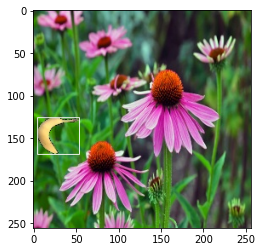

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw

img = d['img']

draw_orig = ImageDraw.Draw(img)
draw_orig.rectangle([
    int(d['xmin']),
    int(d['ymin']),
    int(d['xmax']),
    int(d['ymax'])
    ])
plt.imshow(img)

## Dataloaderによる読み込み

ではデータローダーを使ってバッチで読み込んでみましょう．
以下は，バッチサイズを3としています．

また，画像を読み込んだ直後にtransformで正規化とtorch.tensorへの変換をしています．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import (
    Normalize,
    Compose,
    ToTensor,
)

def get_transform():
    transform_list = [
        ToTensor(),
        Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]),      
    ]

    transform = Compose(transform_list)
    return transform

def transform_img(x, transform):
    return transform(x)


dp_img = dp.iter.FileLister(
    data_root, masks=["*.png"], recursive=True)
dp_img = dp_img.map(
    lambda x: {
        'id': Path(x).stem,
        'img': transform_img(Image.open(x),
                             get_transform())
    })

dp_csv = dp.iter.FileLister([csv_file])
dp_csv = dp_csv.open_files()
dp_csv = dp_csv.parse_csv_as_dict()

dp_img_csv = dp_img.zip_with_iter(
    dp_csv,
    key_fn=lambda x: x['id'],
    ref_key_fn=lambda y: Path(y['img_name']).stem,
    merge_fn=lambda x1, y1: dict(x1, **y1)
    )

dataloader = DataLoader(
    dp_img_csv,
    batch_size=3,
    )

for i, d in enumerate(dataloader):
    print(i, 'id:', d['id'], 'img:', d['img'].shape, 
          'other:', d['xmin'])
    if i > 10:
        break


0 id: ['0', '1', '10'] img: torch.Size([3, 3, 256, 256]) other: ['104', '68', '94']
1 id: ['100', '101', '102'] img: torch.Size([3, 3, 256, 256]) other: ['89', '193', '138']
2 id: ['103', '104', '105'] img: torch.Size([3, 3, 256, 256]) other: ['203', '54', '112']
3 id: ['106', '107', '108'] img: torch.Size([3, 3, 256, 256]) other: ['98', '42', '5']
4 id: ['109', '11', '110'] img: torch.Size([3, 3, 256, 256]) other: ['23', '29', '202']
5 id: ['111', '112', '113'] img: torch.Size([3, 3, 256, 256]) other: ['47', '37', '173']
6 id: ['114', '115', '116'] img: torch.Size([3, 3, 256, 256]) other: ['30', '37', '49']
7 id: ['117', '118', '119'] img: torch.Size([3, 3, 256, 256]) other: ['149', '145', '57']
8 id: ['12', '120', '121'] img: torch.Size([3, 3, 256, 256]) other: ['150', '18', '162']
9 id: ['122', '123', '124'] img: torch.Size([3, 3, 256, 256]) other: ['112', '148', '51']
10 id: ['125', '126', '127'] img: torch.Size([3, 3, 256, 256]) other: ['117', '160', '16']
11 id: ['128', '129', '1

## シャッフル

さて上の例では，`FileLister`が取得するファイル名はある程度ファイル名の順番にソートされています（実際にはコードを見ると[FileListerはos.walkを使って](https://github.com/pytorch/pytorch/blob/76fc690522024d978176b74a73e0222ac4d062de/torch/utils/data/datapipes/utils/common.py#L184)います．[os.walk](https://docs.python.org/ja/3/library/os.html#os.walk)の説明ではpython3.5以降は[os.listdir](https://docs.python.org/ja/3/library/os.html#os.scandir)が使われるとのことで，その説明では順番はin arbitrary orderとのことです）．
通常は学習時に，読み込み順番をランダムにします．


そのためには，データパイプの途中に[`.shuffle()`](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.Shuffler.html#torchdata.datapipes.iter.Shuffler)を挿入します．これは，データパイプで受け渡された要素を一旦バッファに格納し，次に渡す要素はそのバッファの中からランダムに取り出します．


In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
    ToTensor,
)
import torch

def get_transform():
    transform_list = [
        ToTensor(),
        Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]),      
    ]

    transform = Compose(transform_list)
    return transform

def transform_img(x, transform):
    return transform(x)


dp_img = dp.iter.FileLister(
    data_root, masks=["*.png"], recursive=True)
dp_img = dp_img.shuffle()
dp_img = dp_img.map(
    lambda x: {
        'id': Path(x).stem,
        'img': transform_img(Image.open(x),
                             get_transform())
    })

dp_csv = dp.iter.FileLister([csv_file])
dp_csv = dp_csv.open_files()
dp_csv = dp_csv.parse_csv_as_dict()

dp_img_csv = dp_img.zip_with_iter(
    dp_csv,
    key_fn=lambda x: x['id'],
    ref_key_fn=lambda y: Path(y['img_name']).stem,
    merge_fn=lambda x1, y1: dict(x1, **y1)
    )

dataloader = DataLoader(
    dp_img_csv,
    batch_size=3,    
    )

for i, d in enumerate(dataloader):
    print(i, 
          'id:', d['id'], 
          'img:', d['img'].shape, 
          'img_name:', d['img_name'])
    if i > 10:
        break


0 id: ['738', '998', '131'] img: torch.Size([3, 3, 256, 256]) img_name: ['738.png', '998.png', '131.png']
1 id: ['9', '966', '269'] img: torch.Size([3, 3, 256, 256]) img_name: ['9.png', '966.png', '269.png']
2 id: ['587', '790', '944'] img: torch.Size([3, 3, 256, 256]) img_name: ['587.png', '790.png', '944.png']
3 id: ['76', '507', '31'] img: torch.Size([3, 3, 256, 256]) img_name: ['76.png', '507.png', '31.png']
4 id: ['570', '524', '706'] img: torch.Size([3, 3, 256, 256]) img_name: ['570.png', '524.png', '706.png']
5 id: ['466', '25', '64'] img: torch.Size([3, 3, 256, 256]) img_name: ['466.png', '25.png', '64.png']
6 id: ['284', '96', '458'] img: torch.Size([3, 3, 256, 256]) img_name: ['284.png', '96.png', '458.png']
7 id: ['390', '766', '70'] img: torch.Size([3, 3, 256, 256]) img_name: ['390.png', '766.png', '70.png']
8 id: ['608', '231', '722'] img: torch.Size([3, 3, 256, 256]) img_name: ['608.png', '231.png', '722.png']
9 id: ['331', '999', '315'] img: torch.Size([3, 3, 256, 256]) 

これでひとまずDataLoaderが使えるようになりました．

## マルチスレッドとDataLoader

ではDataloaderでnum_workerを指定してマルチスレッドで読み込んでみましょう．以下のコードでは，どのバッチがどのワーカーで読み込まれたのかを表示しています．そのために`torch.utils.data.get_worker_info().id`を使ってワーカー番号を取得し，データパイプ中の要素であるdictに新たな要素として追加しています．

In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
    ToTensor,
)
import torch

def get_transform():
    transform_list = [
        ToTensor(),
        Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]),      
    ]

    transform = Compose(transform_list)
    return transform

def transform_img(x, transform):
    return transform(x)


dp_img = dp.iter.FileLister(
    data_root, masks=["*.png"], recursive=True)
dp_img = dp_img.shuffle()
dp_img = dp_img.map(
    lambda x: {
        'id': Path(x).stem,
        'img': transform_img(Image.open(x),
                             get_transform())
    })

dp_csv = dp.iter.FileLister([csv_file])
dp_csv = dp_csv.open_files()
dp_csv = dp_csv.parse_csv_as_dict()

dp_img_csv = dp_img.zip_with_iter(
    dp_csv,
    key_fn=lambda x: x['id'],
    ref_key_fn=lambda y: Path(y['img_name']).stem,
    merge_fn=lambda x1, y1: dict(x1, **y1)
    )

def add_worker_id(x):
    x['worker'] = torch.utils.data.get_worker_info().id
    return x

dp_img_csv = dp_img_csv.map(add_worker_id)

dataloader = DataLoader(
    dp_img_csv,
    batch_size=3,
    num_workers=3,
    )

for i, d in enumerate(dataloader):
    print(i, 
          'id:', d['id'], 
          'img:', d['img'].shape, 
          'img_name:', d['img_name'], 
          'worker', d['worker'])
    if i > 10:
        break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 id: ['517', '821', '746'] img: torch.Size([3, 3, 256, 256]) img_name: ['517.png', '821.png', '746.png'] worker tensor([0, 0, 0])
1 id: ['517', '821', '746'] img: torch.Size([3, 3, 256, 256]) img_name: ['517.png', '821.png', '746.png'] worker tensor([1, 1, 1])
2 id: ['517', '821', '746'] img: torch.Size([3, 3, 256, 256]) img_name: ['517.png', '821.png', '746.png'] worker tensor([2, 2, 2])
3 id: ['237', '677', '488'] img: torch.Size([3, 3, 256, 256]) img_name: ['237.png', '677.png', '488.png'] worker tensor([0, 0, 0])
4 id: ['237', '677', '488'] img: torch.Size([3, 3, 256, 256]) img_name: ['237.png', '677.png', '488.png'] worker tensor([1, 1, 1])
5 id: ['237', '677', '488'] img: torch.Size([3, 3, 256, 256]) img_name: ['237.png', '677.png', '488.png'] worker tensor([2, 2, 2])
6 id: ['8', '808', '20'] img: torch.Size([3, 3, 256, 256]) img_name: ['8.png', '808.png', '20.png'] worker tensor([0, 0, 0])
7 id: ['8', '808', '20'] img: torch.Size([3, 3, 256, 256]) img_name: ['8.png', '808.png',

各ワーカーで同じデータになってしまっています．
[datapipeのドキュメントにある通り](https://pytorch.org/data/beta/torchdata.datapipes.iter.html)，datapipeがコピーされてワーカーに渡されるからです．

これは問題です．別々のワーカーは別々のデータを処理しなければなりません．



## sharding_filter()：ワーカーに受け渡す要素の選択

一般的には，ワーカーの初期値に与える関数`worker_init_fn`でワーカー番号を取得して初期化するという方法がとられますが，ここではdatapipeの機能を使ってみましょう．

それには[データパイプ中に`sharding_filter()`を挿入します](https://pytorch.org/data/beta/tutorial.html#working-with-dataloader)．こうすると，各ワーカーにコピーされたdatapipeを，各ワーカーでずらしてスキップしながら処理するようになります．

どこに挿入する事もできますが，とりあえず以下のコードでは，すべてのdatapipeの処理が終わったあと，DataLoaderが作成される直前，に`sharding_filter()`を入れています．


In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
    ToTensor,
)
import torch

def get_transform():
    transform_list = [
        ToTensor(),
        Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]),      
    ]

    transform = Compose(transform_list)
    return transform

def transform_img(x, transform):
    return transform(x)


dp_img = dp.iter.FileLister(
    data_root, masks=["*.png"], recursive=True)
dp_img = dp_img.shuffle()
dp_img = dp_img.map(
    lambda x: {
        'id': Path(x).stem,
        'img': transform_img(Image.open(x),
                             get_transform())
    })

dp_csv = dp.iter.FileLister([csv_file])
dp_csv = dp_csv.open_files()
dp_csv = dp_csv.parse_csv_as_dict()

dp_img_csv = dp_img.zip_with_iter(
    dp_csv,
    key_fn=lambda x: x['id'],
    ref_key_fn=lambda y: Path(y['img_name']).stem,
    merge_fn=lambda x1, y1: dict(x1, **y1)
    )

def add_worker_id(x):
    x['worker'] = torch.utils.data.get_worker_info().id
    return x

dp_img_csv = dp_img_csv.map(add_worker_id)

dp_img_csv = dp_img_csv.sharding_filter()


dataloader = DataLoader(
    dp_img_csv,
    batch_size=3,
    num_workers=3,
    )

for i, d in enumerate(dataloader):
    print(i, 
          'id:', d['id'], 
          'img:', d['img'].shape, 
          'img_name:', d['img_name'], 
          'worker', d['worker'])
    if i > 10:
        break


0 id: ['536', '954', '580'] img: torch.Size([3, 3, 256, 256]) img_name: ['536.png', '954.png', '580.png'] worker tensor([0, 0, 0])
1 id: ['352', '750', '900'] img: torch.Size([3, 3, 256, 256]) img_name: ['352.png', '750.png', '900.png'] worker tensor([1, 1, 1])
2 id: ['769', '72', '776'] img: torch.Size([3, 3, 256, 256]) img_name: ['769.png', '72.png', '776.png'] worker tensor([2, 2, 2])
3 id: ['433', '143', '77'] img: torch.Size([3, 3, 256, 256]) img_name: ['433.png', '143.png', '77.png'] worker tensor([0, 0, 0])
4 id: ['460', '202', '859'] img: torch.Size([3, 3, 256, 256]) img_name: ['460.png', '202.png', '859.png'] worker tensor([1, 1, 1])
5 id: ['947', '572', '656'] img: torch.Size([3, 3, 256, 256]) img_name: ['947.png', '572.png', '656.png'] worker tensor([2, 2, 2])
6 id: ['197', '981', '383'] img: torch.Size([3, 3, 256, 256]) img_name: ['197.png', '981.png', '383.png'] worker tensor([0, 0, 0])
7 id: ['540', '326', '63'] img: torch.Size([3, 3, 256, 256]) img_name: ['540.png', '326


## sharding_filter()を挿入する場所を考える


上記のコードでも処理はできるのですが，効率が悪いです．
というのも，`sharding_filter()`の前はすべてのワーカーで同じ処理をするため，ここでは画像の読み込み・デコードのような計算コストとメモリ使用量の大きい処理も，すべてのサンプルについてすべてのワーカーが行っています．

しかし各ワーカーはそれぞれが担当する画像だけを読み込めば良いはずです．
ですので，`sharding_filter()`の後に画像の読み込みを行うほうが効率的です．
以下のコードでは，軽い処理はsharding_filter()の前に行っています．sharding_filter()後では，各ワーカーでは，それぞれのワーカーが担当する要素だけが処理されます．そのときに，重い処理である画像の読み込み・デコードを行っています．

[`sharding_filter()`の説明にあるように](https://pytorch.org/data/beta/tutorial.html#working-with-dataloader)，実際には`sharding_filter()`はできるだけデータパイプの早い段階で行っておくほうが懸命です．ただしそれよりも先に`shuffle()`する必要があります．


In [ ]:
import torchdata.datapipes as dp
from PIL import Image
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
    ToTensor,
)
import torch


def get_transform():
    transform_list = [
        ToTensor(),
        Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]),      
    ]

    transform = Compose(transform_list)
    return transform

def transform_img(x, transform):
    return transform(x)


dp_img = dp.iter.FileLister(
    data_root, masks=["*.png"], recursive=True)
dp_img = dp_img.shuffle()
dp_img = dp_img.map(
    lambda x: {
        'id': Path(x).stem,
        'img': x
    })

dp_csv = dp.iter.FileLister([csv_file])
dp_csv = dp_csv.open_files()
dp_csv = dp_csv.parse_csv_as_dict()

dp_img_csv = dp_img.zip_with_iter(
    dp_csv,
    key_fn=lambda x: x['id'],
    ref_key_fn=lambda y: Path(y['img_name']).stem,
    merge_fn=lambda x1, y1: dict(x1, **y1)
    )

def add_worker_id(x):
    x['worker'] = torch.utils.data.get_worker_info().id
    return x

dp_img_csv = dp_img_csv.map(add_worker_id)

dp_img_csv = dp_img_csv.sharding_filter()


def decode_img(x):
    x['img'] = transform_img(Image.open(x['img']),
                             get_transform())
    return x

dp_img_csv = dp_img_csv.map(decode_img)

dataloader = DataLoader(
    dp_img_csv,
    batch_size=3,
    num_workers=3,
    )

for i, d in enumerate(dataloader):
    print(i, 
          'id:', d['id'], 
          'img:', d['img'].shape,
          'img_name:', d['img_name'], 
          'worker', d['worker'])
    if i > 10:
        break


0 id: ['514', '451', '994'] img: torch.Size([3, 3, 256, 256]) img_name: ['514.png', '451.png', '994.png'] worker tensor([0, 0, 0])
1 id: ['241', '424', '148'] img: torch.Size([3, 3, 256, 256]) img_name: ['241.png', '424.png', '148.png'] worker tensor([1, 1, 1])
2 id: ['709', '824', '550'] img: torch.Size([3, 3, 256, 256]) img_name: ['709.png', '824.png', '550.png'] worker tensor([2, 2, 2])
3 id: ['699', '186', '375'] img: torch.Size([3, 3, 256, 256]) img_name: ['699.png', '186.png', '375.png'] worker tensor([0, 0, 0])
4 id: ['734', '13', '868'] img: torch.Size([3, 3, 256, 256]) img_name: ['734.png', '13.png', '868.png'] worker tensor([1, 1, 1])
5 id: ['718', '110', '389'] img: torch.Size([3, 3, 256, 256]) img_name: ['718.png', '110.png', '389.png'] worker tensor([2, 2, 2])
6 id: ['534', '851', '660'] img: torch.Size([3, 3, 256, 256]) img_name: ['534.png', '851.png', '660.png'] worker tensor([0, 0, 0])
7 id: ['914', '237', '257'] img: torch.Size([3, 3, 256, 256]) img_name: ['914.png', '

## albumentationsを用いたbboxのデータ拡張

ではランダムクロップやフリップなどのデータ拡張をしてみましょう．

一つ問題となるのは，物体検出の場合には真値のbbox情報も幾何変換しなければならないことです．
そこでalbumentationsを使います．このalbumentationsのtransformを使うと，bbox情報も同時に同じ変換を適用することができます．

データ拡張前後の画像を並べてbboxを描画してみたいので，元の画像`img_orig`とデータ拡張変換後の画像`img`を両方データパイプに流すことにしています．それに対応して，元のbboxと変換後のbboxの両方の座標も保持しておきます．


0 id: ['559', '965', '400', '395'] img: torch.Size([4, 3, 224, 224]) bboxes: tensor([[139.8121,  34.0105, 195.4362,  87.9581],
        [ 46.7064, 146.3762,  99.1319, 211.8020],
        [146.8444,  30.2703, 204.0889,  81.1243],
        [160.2759,   0.0000, 204.6897,   3.6522]], dtype=torch.float64) img_orig: torch.Size([4, 256, 256, 3]) bboxes_orig: tensor([[107.,  94., 144., 140.],
        [ 54., 134., 109., 193.],
        [135.,  76., 181., 118.],
        [185.,   6., 231.,  63.]], dtype=torch.float64) img_name: ['559.png', '965.png', '400.png', '395.png'] worker tensor([0, 0, 0, 0])
1 id: ['735', '399', '167', '863'] img: torch.Size([4, 3, 224, 224]) bboxes: tensor([[ 56.9825,   0.0000, 176.8421,  41.8462],
        [  0.0000,  70.5414,  21.2800, 131.1823],
        [174.0637, 105.1077, 224.0000, 189.5385],
        [171.0207, 147.3422, 207.2697, 192.1422]], dtype=torch.float64) img_orig: torch.Size([4, 256, 256, 3]) bboxes_orig: tensor([[157.,  72., 218., 134.],
        [ 19., 119.,  7

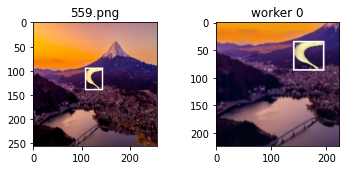

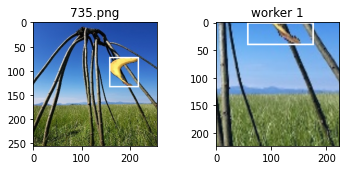

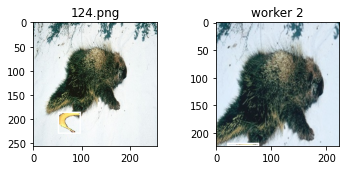

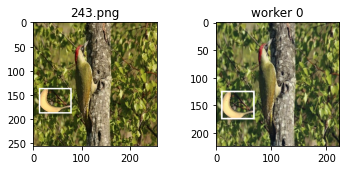

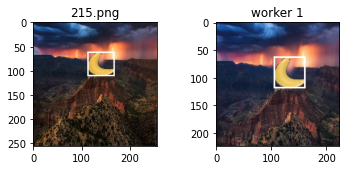

In [ ]:
import torchdata.datapipes as dp
from PIL import Image, ImageDraw
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
    ToTensor,
)
import torch
import albumentations as A
import albumentations.pytorch as Ap
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline


def get_transform():
    transform_list = [
        A.RandomResizedCrop(224, 224),
        A.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]),
        Ap.ToTensorV2(),  # HWC --> CHW
    ]

    transform = A.Compose(
        transform_list,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['label']
            )
        )
    
    return transform


def get_bboxes(x):
    x['bboxes_orig'] = [
        float(x['xmin']),
        float(x['ymin']),
        float(x['xmax']),
        float(x['ymax']),
        ]
    return x


def transform_img(x, transform):
    return transform(
        image=x['img_orig'],
        bboxes=[
            x['bboxes_orig'],  # bbox of 1st object
        ],
        label=[
            x['label'],  # 1st object
        ])

def decode_img(x):
    x['img_orig'] = np.array(Image.open(x['img']))

    while True:
        transformed = transform_img(x, get_transform())

        # break only if bbox is in the cropped image
        if len(transformed['bboxes']) > 0:
            x['img'] = transformed['image']
            x['bboxes'] = transformed['bboxes'][0]
            x['label'] = transformed['label'][0]
            break

    return x


def add_worker_id(x):
    x['worker'] = torch.utils.data.get_worker_info().id
    return x


def print_data(x, prefix=""):
    print(prefix, x)
    return x


def draw_rectangle(img, bbox, color=(255, 255, 255), thickness=2):
    """
    img: tensor (H, W, C), uint8
    bbox: tensor [xmin, ymin, xmax, ymax], float
    """

    img = img.detach().cpu().numpy().astype(np.uint8)
    bbox = bbox.detach().cpu().numpy().astype(np.uint8)
    # print(img.shape, type(img), img.dtype, bbox, type(bbox), bbox.dtype, img.max(), img.min())
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    draw.rectangle(list(bbox), width=3)
    return np.array(img)


def normalize(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return img



def get_dataset(data_root, csv_file):

    dp_img = dp.iter.FileLister(
        data_root, masks=["*.png"], recursive=True)
    dp_img = dp_img.shuffle()
    dp_img = dp_img.map(
        lambda x: {
            'id': Path(x).stem,
            'img': x
        })

    dp_csv = dp.iter.FileLister([csv_file])
    dp_csv = dp_csv.open_files()
    dp_csv = dp_csv.parse_csv_as_dict()
    dp_csv = dp_csv.map(get_bboxes)

    dp_img_csv = dp_img.zip_with_iter(
        dp_csv,
        key_fn=lambda x: x['id'],
        ref_key_fn=lambda y: Path(y['img_name']).stem,
        merge_fn=lambda x1, y1: dict(x1, **y1)
        )
    dp_img_csv = dp_img_csv.map(add_worker_id)
    dp_img_csv = dp_img_csv.sharding_filter()
    dp_img_csv = dp_img_csv.map(decode_img)

    return dp_img_csv


dataloader = DataLoader(
    get_dataset(data_root, csv_file),
    batch_size=4,
    num_workers=3,
    )


for i, d in enumerate(dataloader):
    d['bboxes'] = torch.stack(d['bboxes']).permute(1, 0)
    d['bboxes_orig'] = torch.stack(d['bboxes_orig']).permute(1, 0)

    print(i,
          'id:', d['id'], 
          'img:', d['img'].shape, # d['img'].max(),
          'bboxes:', d['bboxes'],
          'img_orig:', d['img_orig'].shape, # d['img_orig'].max(),
          'bboxes_orig:', d['bboxes_orig'],
        #   'label', d['label'],
          'img_name:', d['img_name'], 
          'worker', d['worker'])

    fig = plt.figure(figsize=(12, 5))

    ax = fig.add_subplot(221)
    img_orig = draw_rectangle(d['img_orig'][0], d['bboxes_orig'][0])
    ax.imshow(img_orig)
    ax.set_title(d['img_name'][0])

    ax = fig.add_subplot(211)
    img_orig = draw_rectangle(normalize(d['img'][0].permute(1, 2, 0)), d['bboxes'][0])
    plt.imshow(img_orig)
    ax.set_title("worker " + str(d['worker'][0].item()))


    if i > 3:
        break



In [ ]:
# import torchdata.datapipes as dp
# from PIL import Image, ImageDraw
# import numpy as np
# from pathlib import Path
# from torch.utils.data import DataLoader
# from torchvision import transforms
# from torchvision.transforms import (
#     RandomResizedCrop,
#     Normalize,
#     RandomHorizontalFlip,
#     Compose,
#     ToTensor,
# )
# import torch
# import albumentations as A
# import albumentations.pytorch as Ap
# from functools import partial

# import matplotlib.pyplot as plt
# %matplotlib inline


# def get_transform():
#     transform_list = [
#         A.RandomResizedCrop(224, 224),
#         A.Normalize(
#             [0.485, 0.456, 0.406],
#             [0.229, 0.224, 0.225]),
#         Ap.ToTensorV2(),  # HWC --> CHW
#     ]

#     transform = A.Compose(
#         transform_list,
#         bbox_params=A.BboxParams(
#             format='pascal_voc',
#             label_fields=['label']
#             )
#         )
    
#     return transform


# def get_bboxes(x):
#     x['bboxes_orig'] = [
#         float(x['xmin']),
#         float(x['ymin']),
#         float(x['xmax']),
#         float(x['ymax']),
#         ]
#     return x


# def transform_img(x, transform=get_transform()):

#     while True:
#         transformed = transform(
#             image=x['img_orig'],
#             bboxes=[
#                 x['bboxes_orig'],  # bbox of 1st object
#             ],
#             label=[
#                 x['label'],  # 1st object
#             ])

#         # break only if bbox is in the cropped image
#         if len(transformed['bboxes']) > 0:
#             x['img'] = transformed['image']
#             x['bboxes'] = transformed['bboxes'][0]
#             x['label'] = transformed['label'][0]
#             break

#     return x


# def decode_img(x):
#     x['img_orig'] = np.array(Image.open(x['img']))
#     return x


# def add_worker_id(x):
#     x['worker'] = torch.utils.data.get_worker_info().id
#     return x


# def print_data(x, prefix=""):
#     print(prefix, x)
#     return x


# def draw_rectangle(img, bbox, color=(255, 255, 255), thickness=2):
#     """
#     img: tensor (H, W, C), uint8
#     bbox: tensor [xmin, ymin, xmax, ymax], float
#     """

#     img = img.detach().cpu().numpy().astype(np.uint8)
#     bbox = bbox.detach().cpu().numpy().astype(np.uint8)
#     # print(img.shape, type(img), img.dtype, bbox, type(bbox), bbox.dtype, img.max(), img.min())
#     img = Image.fromarray(img)
#     draw = ImageDraw.Draw(img)
#     draw.rectangle(list(bbox), width=3)
#     return np.array(img)


# def normalize(img):
#     img -= img.min()
#     img /= img.max()
#     img *= 255
#     return img



# def get_dataset(data_root, csv_file):

#     dp_img = dp.iter.FileLister(
#         data_root, masks=["*.png"], recursive=True)
#     dp_img = dp_img.shuffle()
#     dp_img = dp_img.map(
#         lambda x: {
#             'id': Path(x).stem,
#             'img': x
#         })

#     dp_csv = dp.iter.FileLister([csv_file])
#     dp_csv = dp_csv.open_files()
#     dp_csv = dp_csv.parse_csv_as_dict()
#     dp_csv = dp_csv.map(get_bboxes)

#     dp_img_csv = dp_img.zip_with_iter(
#         dp_csv,
#         key_fn=lambda x: x['id'],
#         ref_key_fn=lambda y: Path(y['img_name']).stem,
#         merge_fn=lambda x1, y1: dict(x1, **y1)
#         )
#     dp_img_csv = dp_img_csv.sharding_filter()
#     dp_img_csv = dp_img_csv.map(decode_img)
#     dp_img_csv = dp_img_csv.map(transform_img)
#     dp_img_csv = dp_img_csv.map(add_worker_id)

#     return dp_img_csv


# dataloader = DataLoader(
#     get_dataset(data_root, csv_file),
#     batch_size=4,
#     num_workers=3,
#     )


# for i, d in enumerate(dataloader):
#     d['bboxes'] = torch.stack(d['bboxes']).permute(1, 0)
#     d['bboxes_orig'] = torch.stack(d['bboxes_orig']).permute(1, 0)

#     print(i,
#           'id:', d['id'], 
#           'img:', d['img'].shape, # d['img'].max(),
#           'bboxes:', d['bboxes'],
#           'img_orig:', d['img_orig'].shape, # d['img_orig'].max(),
#           'bboxes_orig:', d['bboxes_orig'],
#         #   'label', d['label'],
#           'img_name:', d['img_name'], 
#           'worker', d['worker'])


#     fig = plt.figure(figsize=(12, 5))

#     ax = fig.add_subplot(221)
#     img_orig = draw_rectangle(d['img_orig'][0], d['bboxes_orig'][0])
#     ax.imshow(img_orig)
#     ax.set_title(d['img_name'][0])

#     ax = fig.add_subplot(211)
#     img_orig = draw_rectangle(normalize(d['img'][0].permute(1, 2, 0)), d['bboxes'][0])
#     plt.imshow(img_orig)
#     ax.set_title("worker " + str(d['worker'][0].item()))


#     if i > 3:
#         break



上記のコードのbboxesとbboxes_origの情報は，データローダーで取得されたときに，使いやすい形になっていないので，実際にDataLoaderからバッチを取得した後で，torch.stackとtensor.permuteを使って整形していました．

あまりきれいではないので，その部分をcollate関数にしたものが以下のコードです．
ついでに，decode_imgとtransform_imgも整理しました．

0 id: ['815', '645', '494', '94'] img: torch.Size([4, 3, 224, 224]) bboxes: tensor([[213.6615, 135.2453, 224.0000, 191.5975],
        [132.5333,   0.0000, 176.4000,  47.8545],
        [155.9494,  95.4754, 207.9325, 145.6612],
        [  0.0000,   9.7391,  87.7333,  87.6522]], dtype=torch.float64) img_orig: torch.Size([4, 256, 256, 3]) bboxes_orig: tensor([[199., 176., 244., 216.],
        [156.,  31., 203.,  78.],
        [171.,  84., 226., 125.],
        [ 16.,  55.,  69., 103.]], dtype=torch.float64) img_name: ['815.png', '645.png', '494.png', '94.png'] worker tensor([0, 0, 0, 0])
1 id: ['429', '21', '326', '673'] img: torch.Size([4, 3, 224, 224]) bboxes: tensor([[ 28.9378,  90.3860,  78.2392, 172.9123],
        [144.7805,  70.0000, 185.7561, 116.0000],
        [139.6706,  54.3689, 224.0000, 178.3301],
        [ 71.4601, 135.7576, 131.9264, 216.0808]], dtype=torch.float64) img_orig: torch.Size([4, 256, 256, 3]) bboxes_orig: tensor([[ 56.,  90., 102., 153.],
        [159.,  73., 204.,

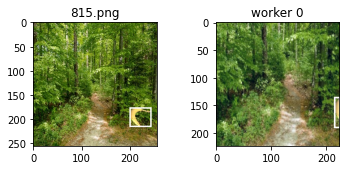

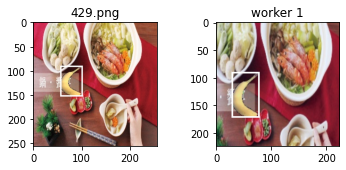

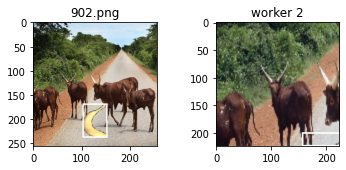

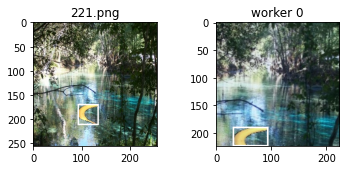

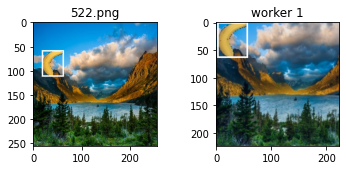

In [ ]:
import torchdata.datapipes as dp
from PIL import Image, ImageDraw
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import (
    RandomResizedCrop,
    Normalize,
    RandomHorizontalFlip,
    Compose,
    ToTensor,
)
import torch
import albumentations as A
import albumentations.pytorch as Ap
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline


def get_transform():
    transform_list = [
        A.RandomResizedCrop(224, 224),
        A.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]),
        Ap.ToTensorV2(),  # HWC --> CHW
    ]

    transform = A.Compose(
        transform_list,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['label']
            )
        )
    
    return transform


def get_bboxes(x):
    x['bboxes_orig'] = [
        float(x['xmin']),
        float(x['ymin']),
        float(x['xmax']),
        float(x['ymax']),
        ]
    return x


def transform_img(x, transform=get_transform()):

    while True:
        transformed = transform(
            image=x['img_orig'],
            bboxes=[
                x['bboxes_orig'],  # bbox of 1st object
            ],
            label=[
                x['label'],  # 1st object
            ])

        # break only if bbox is in the cropped image
        if len(transformed['bboxes']) > 0:
            x['img'] = transformed['image']
            x['bboxes'] = transformed['bboxes'][0]
            x['label'] = transformed['label'][0]
            break

    return x


def decode_img(x):
    x['img_orig'] = np.array(Image.open(x['img']))
    return x


def add_worker_id(x):
    x['worker'] = torch.utils.data.get_worker_info().id
    return x


def print_data(x, prefix=""):
    print(prefix, x)
    return x


def draw_rectangle(img, bbox, color=(255, 255, 255), thickness=2):
    """
    img: tensor (H, W, C), uint8
    bbox: tensor [xmin, ymin, xmax, ymax], float
    """

    img = img.detach().cpu().numpy().astype(np.uint8)
    bbox = bbox.detach().cpu().numpy().astype(np.uint8)
    # print(img.shape, type(img), img.dtype, bbox, type(bbox), bbox.dtype, img.max(), img.min())
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    draw.rectangle(list(bbox), width=3)
    return np.array(img)


def normalize(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return img



def get_dataset(data_root, csv_file):

    dp_img = dp.iter.FileLister(
        data_root, masks=["*.png"], recursive=True)
    dp_img = dp_img.shuffle()
    dp_img = dp_img.map(
        lambda x: {
            'id': Path(x).stem,
            'img': x
        })

    dp_csv = dp.iter.FileLister([csv_file])
    dp_csv = dp_csv.open_files()
    dp_csv = dp_csv.parse_csv_as_dict()
    dp_csv = dp_csv.map(get_bboxes)

    dp_img_csv = dp_img.zip_with_iter(
        dp_csv,
        key_fn=lambda x: x['id'],
        ref_key_fn=lambda y: Path(y['img_name']).stem,
        merge_fn=lambda x1, y1: dict(x1, **y1)
        )
    dp_img_csv = dp_img_csv.sharding_filter()
    dp_img_csv = dp_img_csv.map(decode_img)
    dp_img_csv = dp_img_csv.map(transform_img)
    dp_img_csv = dp_img_csv.map(add_worker_id)

    return dp_img_csv


def my_collation(batch):
    batch = torch.utils.data.default_collate(batch)
    batch['bboxes'] = torch.stack(batch['bboxes']).permute(1, 0)
    batch['bboxes_orig'] = torch.stack(batch['bboxes_orig']).permute(1, 0)
    return batch


dataloader = DataLoader(
    get_dataset(data_root, csv_file),
    batch_size=4,
    num_workers=3,
    collate_fn=my_collation,
    )


for i, d in enumerate(dataloader):

    print(i,
          'id:', d['id'], 
          'img:', d['img'].shape, # d['img'].max(),
          'bboxes:', d['bboxes'],
          'img_orig:', d['img_orig'].shape, # d['img_orig'].max(),
          'bboxes_orig:', d['bboxes_orig'],
        #   'label', d['label'],
          'img_name:', d['img_name'], 
          'worker', d['worker'])


    fig = plt.figure(figsize=(12, 5))

    ax = fig.add_subplot(221)
    img_orig = draw_rectangle(d['img_orig'][0], d['bboxes_orig'][0])
    ax.imshow(img_orig)
    ax.set_title(d['img_name'][0])

    ax = fig.add_subplot(211)
    img_orig = draw_rectangle(normalize(d['img'][0].permute(1, 2, 0)), d['bboxes'][0])
    plt.imshow(img_orig)
    ax.set_title("worker " + str(d['worker'][0].item()))


    if i > 3:
        break



# データサイズ

通常のdatasetオブジェクトと異なり，datapipeはlen()で長さ（つまりデータセットのサイズ）を取得することはできません．これはそもそもtorchdataの設計思想が理由です．取得するデータのソースがローカルファイルならファイル数を数えることができますが，オンライン上のファイルやtarアーカイブファイルなどからデータを取り出すときには，残りいくつあるのかは分かりません（全部取り出して空になって初めていくつだったのかが分かるのです）．またfilterやzipなどで要素数が変化することも理由です（紹介していませんが[`flatmap`](https://pytorch.org/data/beta/generated/torchdata.datapipes.iter.FlatMapper.html#torchdata.datapipes.iter.FlatMapper)はデータを増やす例です）．

# DDP